In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('StoreDemand.csv')
display(df.head())
display(df.tail())

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [5]:
df.shape

(913000, 4)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [7]:
df.describe()   

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


<h3>Feature engineering</h3>

In [8]:
parts = df["date"].str.split("-", n = 3, expand = True)
df["year"]= parts[0].astype('int')
df["month"]= parts[1].astype('int')
df["day"]= parts[2].astype('int')
df.head()

,date,store,item,sales,year,month,day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5


In [9]:
from datetime import datetime

def weekend_or_weekday(year, month, day):
    d = datetime(year, month, day)
    return 1 if d.weekday() > 4 else 0

df['weekend'] = df.apply(lambda x: weekend_or_weekday(x['year'], x['month'], x['day']), axis=1)

In [12]:
from datetime import date
import holidays

india_holidays = holidays.country_holidays('IN')
df['holidays'] = df['date'].apply(lambda x: 1 if india_holidays.get(x) else 0)

Now, let's add some cyclical features.these are important for capturing seasonality in time series data.

In [ ]:

df['m1'] = np.sin(df['month'] * (2 * np.pi / 12))
df['m2'] = np.cos(df['month'] * (2 * np.pi / 12))
df.head()

,date,store,item,sales,year,month,day,weekend,holidays,m1,m2
0,2013-01-01,1,1,13,2013,1,1,0,0,0.5,0.866025
1,2013-01-02,1,1,11,2013,1,2,0,0,0.5,0.866025
2,2013-01-03,1,1,14,2013,1,3,0,0,0.5,0.866025
3,2013-01-04,1,1,13,2013,1,4,0,0,0.5,0.866025
4,2013-01-05,1,1,10,2013,1,5,1,0,0.5,0.866025


Let's have a column whose value indicates which day of the week it is.


In [15]:
def which_day(year, month, day):
    return datetime(year, month, day).weekday()

df['weekday'] = df.apply(lambda x: which_day(x['year'], x['month'], x['day']), axis=1)

In [17]:
df['store'].nunique(), df['item'].nunique()

(10, 50)

50 unique products and 10 unique stores are reffered from above unique values.
now let's visualize the relationship btw all the columns in the data

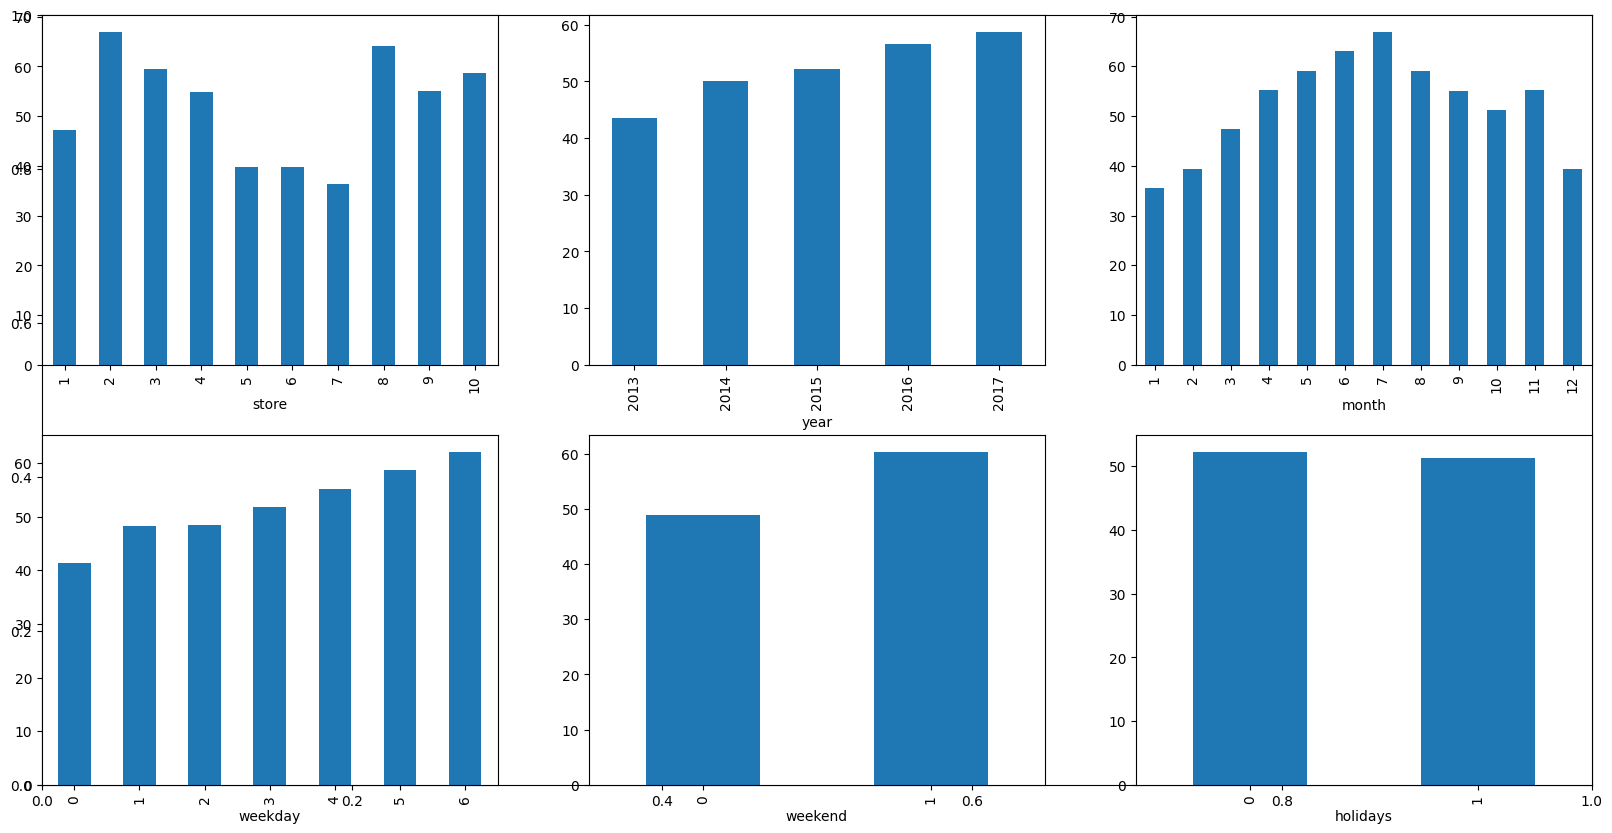

In [18]:
df['weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
features = ['store', 'year', 'month', 'weekday', 'weekend', 'holidays']

plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    df.groupby(col).mean()['sales'].plot.bar()
plt.show()

the variation of stock during the month end

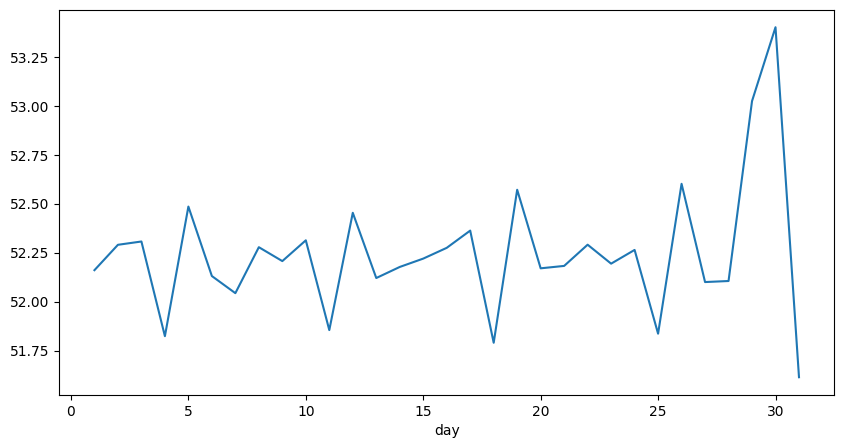

In [19]:
plt.figure(figsize=(10,5))
df.groupby('day').mean()['sales'].plot()
plt.show()

#Moving Average: it is a statistical calculation used to analyze data points by creating a series of averages of different subsets of the full data set. In time series data, moving averages help smooth out short-term fluctuations and highlight longer-term trends or cycles.

moving average for 30 days period help to smooth out short-term fluctuations and highlight longer-term trend or cycles in the data

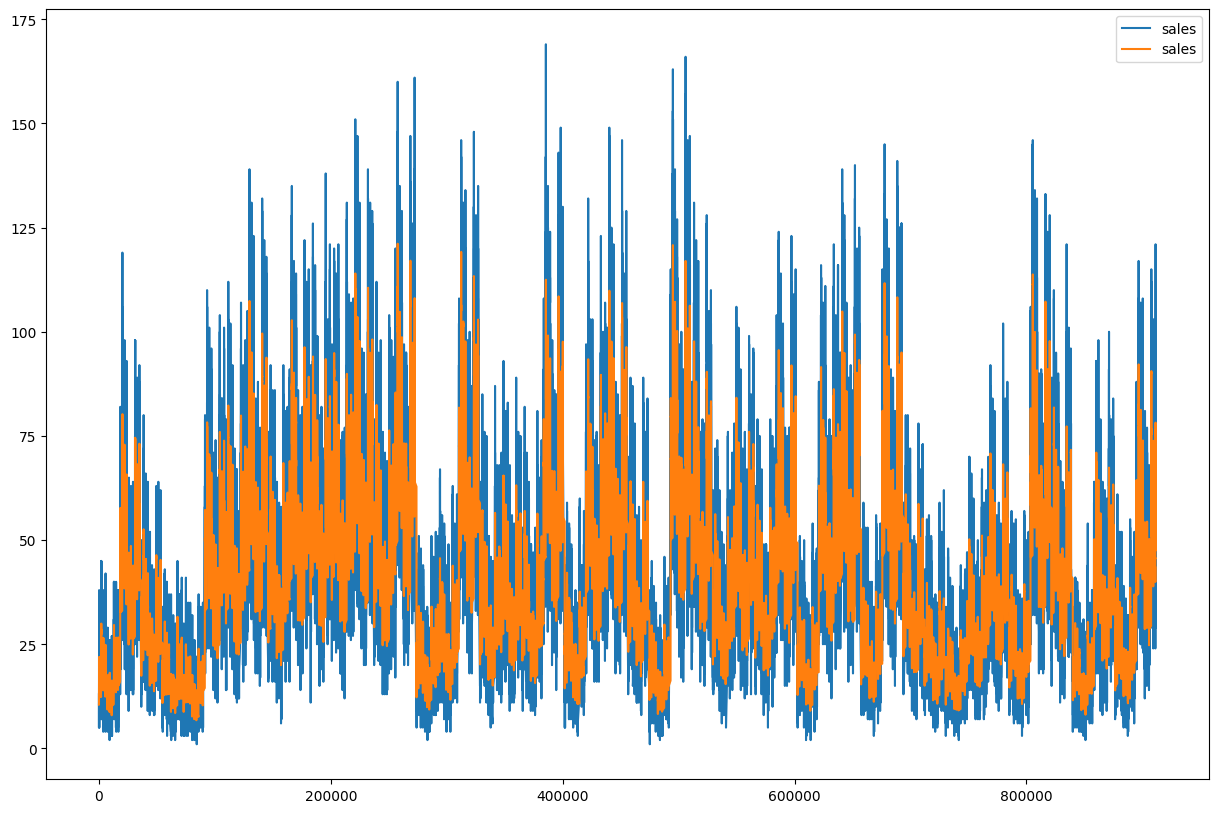

In [20]:
plt.figure(figsize=(15, 10))

# Calculating Simple Moving Average 
# for a window period of 30 days
window_size = 30
data = df[df['year']==2013]
windows = data['sales'].rolling(window_size)
sma = windows.mean()
sma = sma[window_size - 1:]

data['sales'].plot()
sma.plot()
plt.legend()
plt.show()

<h3>Finding outliers</h3>

 these are data points that differ significantly from other observations. They can occur due to variability in the data or may indicate experimental errors. Identifying and handling outliers is crucial as they can skew and mislead the training process of machine learning models, leading to poor performance.

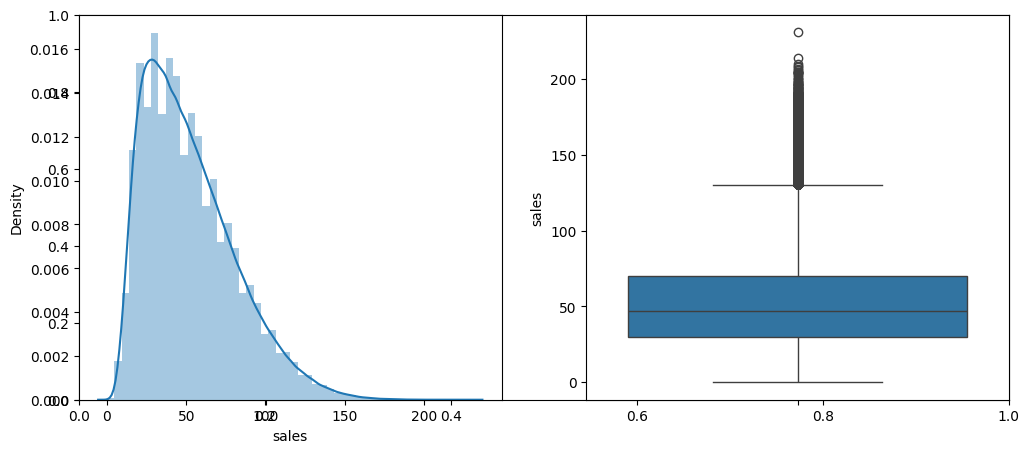

In [21]:
plt.subplots(figsize=(12, 5))
plt.subplot(1, 2, 1)
sb.distplot(df['sales'])

plt.subplot(1, 2, 2)
sb.boxplot(df['sales'])
plt.show()

-as from the above plots the dataset is right skewed and there are some outliers present in the data.

-right skews are basically means that the tail on the right side of the distribution is longer or fatter than the left side.

-right skewed data can affect the performance of machine learning models, especially those that assume a normal distribution of the data. Outliers can also skew the results and lead to inaccurate predictions.

-To handle this, we can apply a log transformation to the sales data to reduce the skewness and minimize the impact of outliers.


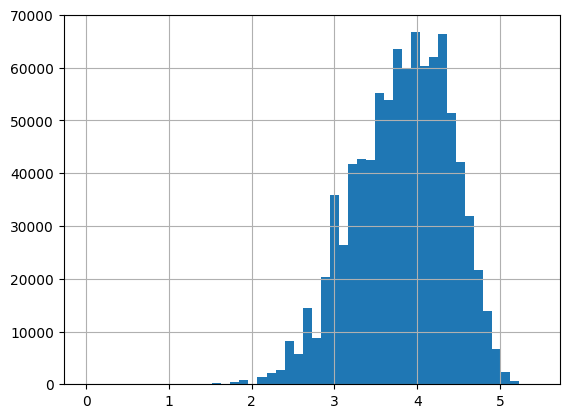

In [23]:
#log transformation to reduce skewness
df['sales'] = np.log1p(df['sales'])
df['sales'].hist(bins=50)
plt.show()

the correlation between the features of the data: 

the correlation values range from -1 to 1. A value closer to 1 indicates a strong positive correlation, meaning that as one feature increases, the other feature tends to increase as well. 

A value closer to -1 indicates a strong negative correlation, meaning that as one feature increases, the other feature tends to decrease. A value around 0 indicates little to no correlation between the features.

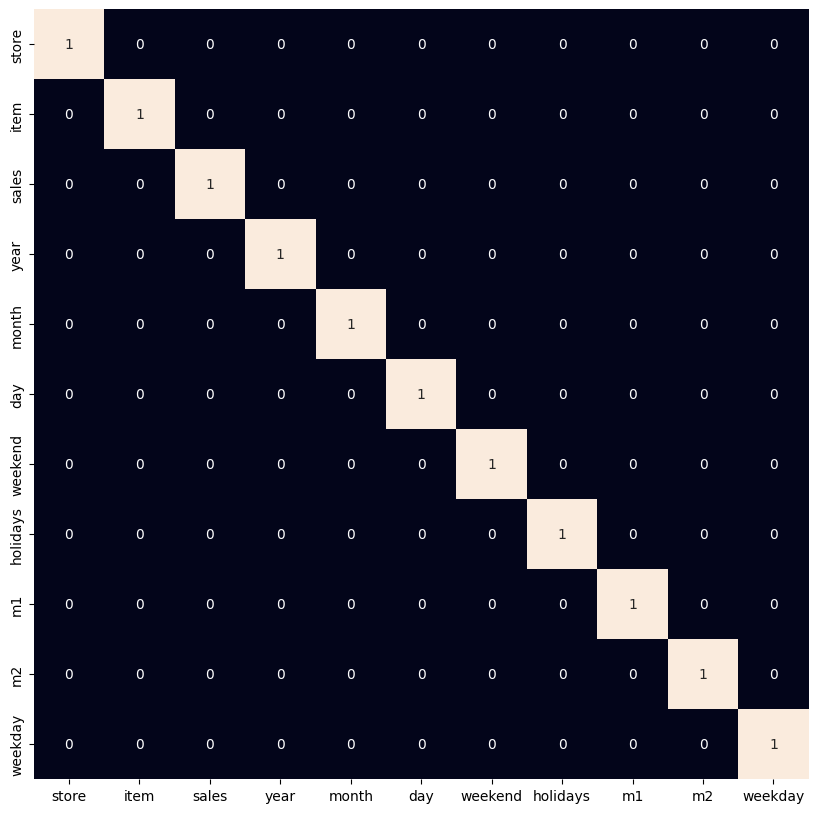

In [ ]:
#corr() is used to compute the pairwise correlation of columns, excluding NA/null values.
plt.figure(figsize=(10, 10))
sb.heatmap(df.corr() > 0.8,
           annot=True,
           cbar=False)
plt.show()

In [ ]:
df = df[df['sales']<140]

why 140 because after log transformation there are some outliers present in the data which is greater than 140

<h3>Model training</h3>

In [ ]:
features = df.drop(['sales', 'year'], axis=1)# why sales and year are removed because sales is the target variable and year is not needed for prediction
target = df['sales'].values


X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                                  test_size = 0.05,
                                                  random_state=22)
X_train.shape, X_val.shape

((867350, 9), (45650, 9))

In [26]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [27]:
models = [LinearRegression(), XGBRegressor(), Lasso(), Ridge()]# four models are used for training the data

for i in range(4):
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')

    train_preds = models[i].predict(X_train)
    print('Training Error : ', mae(Y_train, train_preds))

    val_preds = models[i].predict(X_val)
    print('Validation Error : ', mae(Y_val, val_preds))
    print()

LinearRegression() : 
Training Error :  0.4409007607991826
Validation Error :  0.4422315138696877

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...) : 
Training Error :  0.14235849957640306
Validation Error :  0.14187702802157506

Lasso() : 
Training Error :  0.47227570317909
Validation Error :  0.4

<h4>After training and evaluating the models, we observe that XGBoost performs the best with the lowest validation error. This demonstrates the power of ensemble methods in capturing complex patterns in sales data.</h4>